# INFORMACIÓN DEL PROYECTO: JORGE ALONSO EDA

<div style="text-align: center;">
  <img src="./recursos/Automobile-Data.jpg" alt="Gráfico de ventas" width="700" />
</div>

### TÍTULO

**Estudio de datos almacenados por estaciones de carga para vehiculos eléctricos**

### TEMA

El tema principal es el estudio de los datos almacenados por puntos de recarga de coches eléctricos.

Para ello se va a utilizar el data set "Electric Vehicle Charging Patterns" estraido con una API de Kaggle. Los datos extraidos serán tratados y representados con el objetivo de estudar la forma en la que los conductores utilizan dichas estaciones de carga. Los datos extraidos son de conductores de EEUU durante los meses de enero y febrero de 2024. Las ciudades en las que se ubican los puntos de carga son: Houston, San Francisco, Los Angeles, Chicago y New York.

Los modelos de coches de os que se han recolectados los datos es de los 5 siguientes 5 vehículos: BMW i3, Hyundai Kona, Chevy Bolt, Nissan Leaf y Tesla Model 3. 


Este data set, se compone de un total de 20 columnas diferentes (cada una es un tipo de variable) y 1320 registros únicos de carga de EVs.

### HIPÓTESIS

Hipotesis 1: "Tesla es la marca más eficiente"<br>
Hipotesis 2: "Los cargadores de tipo DC Fast Charger son mas utilizados para distancias largas"<br>
Hipotesis 3: "Las ciudades con gran densidad de población, tienen mayor acceso a cargadores eléctricos, por lo que cargan más frecuentemente la batería del vehículo"

## OBTENCIÓN DE LOS DATOS

### DATASETS Y FUENTES ALTERNATIVAS DE DATOS

El siguiente data set sobre estaciones de carga de vehiculos eléctricos se muestra en bruto, es decir, se muestra tal cual ha sido descargado.

Durante el desarrollo del EDA se elavorará un proceso ETL, para poder sacar el máximo partido a este data set.

In [22]:
import hashlib
import requests
import datetime
import pandas as pd
import json
import kagglehub
from kagglehub import KaggleDatasetAdapter
import kaggle

In [23]:
#Descargar el data set de la api de kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files("valakhorasani/electric-vehicle-charging-patterns", path="apiVehiculos", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/valakhorasani/electric-vehicle-charging-patterns


In [24]:
ds_evs = pd.read_csv('./apiVehiculos/ev_charging_patterns.csv')

In [25]:
ds_evs.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [26]:
ds_evs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

In [27]:
ds_evs["Vehicle Model"].unique()

array(['BMW i3', 'Hyundai Kona', 'Chevy Bolt', 'Nissan Leaf',
       'Tesla Model 3'], dtype=object)

In [28]:
ds_evs["Charging Station Location"].unique()

array(['Houston', 'San Francisco', 'Los Angeles', 'Chicago', 'New York'],
      dtype=object)

In [29]:
ds_evs["Charger Type"].unique()

array(['DC Fast Charger', 'Level 1', 'Level 2'], dtype=object)

### Comenzamos a limpizar y calcular nuevos datos a partir del Data Set principal ###

In [30]:
# Creamos la columna % carga por registo
ds_evs["% charged"] = ds_evs["State of Charge (End %)"] - ds_evs["State of Charge (Start %)"]
ds_evs["Charging Energy Cost (USD /kW)"] = ds_evs["Charging Cost (USD)"] / ds_evs["Charging Rate (kW)"]

In [31]:
#Mostrar todas las columnas
pd.set_option('display.max_columns', None)
ds_evs.head(5)

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,% charged,Charging Energy Cost (USD /kW)
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter,56.748386,0.359660
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver,74.548566,0.688723
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter,63.063011,1.296351
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler,16.504325,0.396445
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,9.484836,0.994690


In [32]:
#Identificas variables numericas y categoricas

In [41]:
# Quitar las columnas con % carga negativa (no está bien registrado o existen anomalias, mejor quitarlas)

mascara_carga = ds_evs["% charged"] >= 0
ds_evs_clean = ds_evs[mascara_carga]
ds_evs_clean.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,% charged,Charging Energy Cost (USD /kW)
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter,56.748386,0.359660
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver,74.548566,0.688723
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter,63.063011,1.296351
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler,16.504325,0.396445
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,9.484836,0.994690


In [34]:
#Info del data set limpio

ds_evs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1052 entries, 0 to 1317
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1052 non-null   object 
 1   Vehicle Model                             1052 non-null   object 
 2   Battery Capacity (kWh)                    1052 non-null   float64
 3   Charging Station ID                       1052 non-null   object 
 4   Charging Station Location                 1052 non-null   object 
 5   Charging Start Time                       1052 non-null   object 
 6   Charging End Time                         1052 non-null   object 
 7   Energy Consumed (kWh)                     992 non-null    float64
 8   Charging Duration (hours)                 1052 non-null   float64
 9   Charging Rate (kW)                        999 non-null    float64
 10  Charging Cost (USD)                      

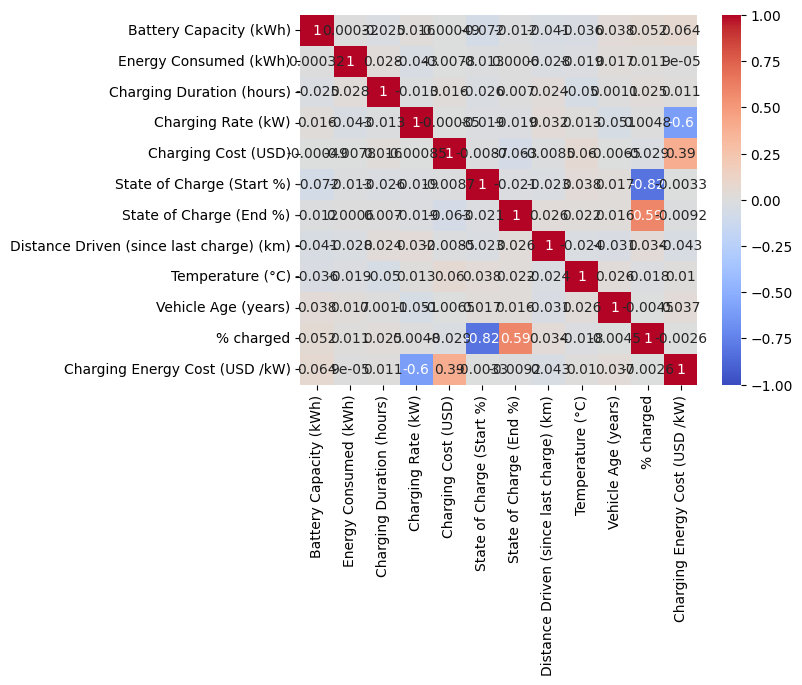

In [35]:
#Ver correlacion entre variables numéricas
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(ds_evs.corr(numeric_only=True), annot=True, cmap="coolwarm", vmin=-1);


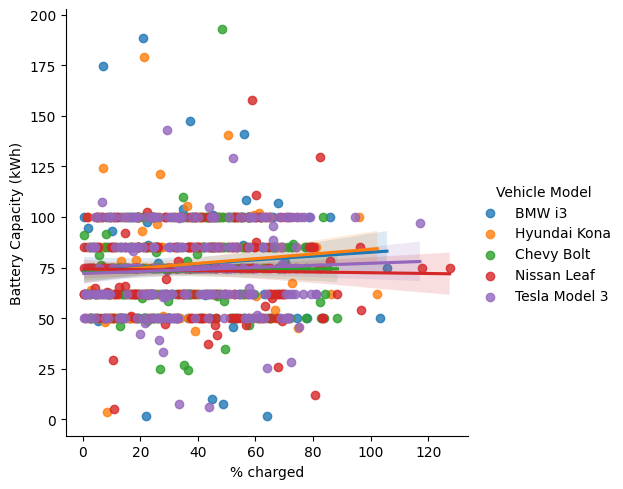

In [36]:
sns.lmplot(x="% charged", y="Battery Capacity (kWh)", data=ds_evs_clean, fit_reg=True, hue="Vehicle Model");

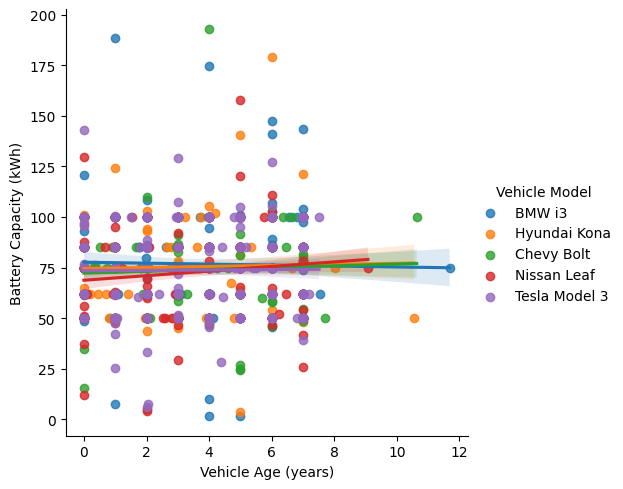

In [37]:
sns.lmplot(x="Vehicle Age (years)", y="Battery Capacity (kWh)", data=ds_evs, fit_reg=True, hue="Vehicle Model");


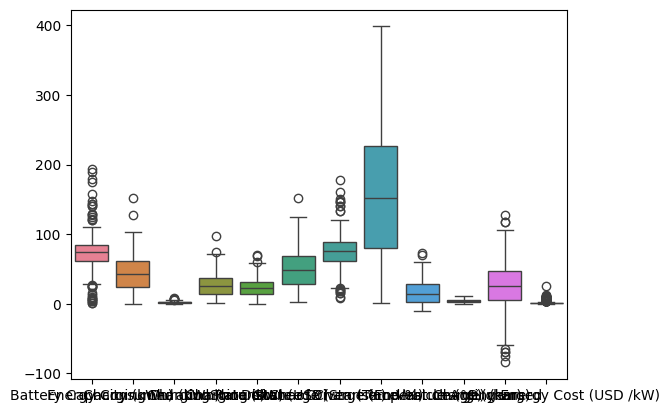

In [38]:
#BoxPlot, de toas las variables numericas

sns.boxplot(ds_evs);

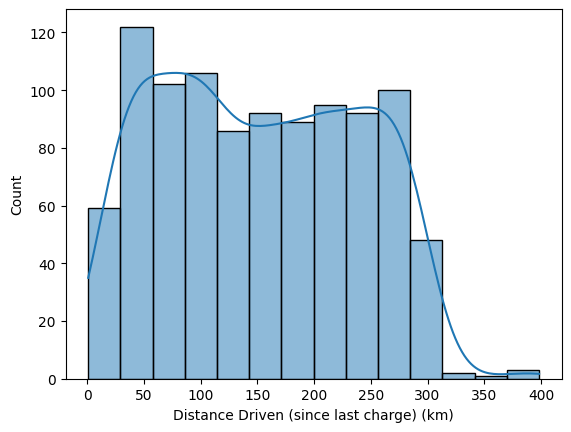

In [43]:
#Interesa ver cuando es el % de carga más frecuente por los conductores de cada visita

sns.histplot(ds_evs_clean["Distance Driven (since last charge) (km)"], kde=True);

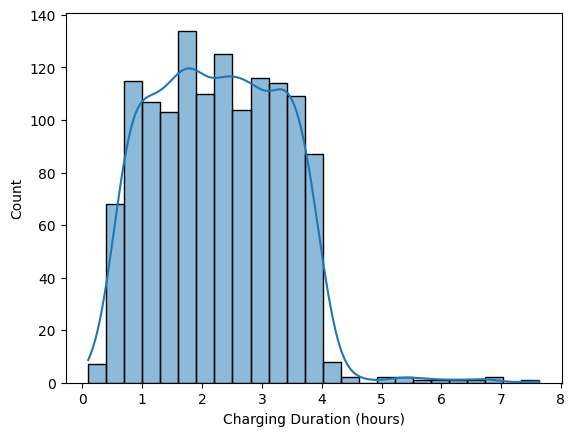

In [ ]:
sns.histplot(ds_evs_clean["% charged"], kde=True);